In [1]:
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
from datetime import datetime
now = datetime.now()

shutil.rmtree('D:/MATLAB/OSU/OSU-automapping/Train/log/', ignore_errors=True)

sess = tf.InteractiveSession()

In [2]:
learning_rate = 1e-4
channels_input = 64
channels_output = 64

fc_input_dim = int(128*128*channels_output/4**5)
fc_hidden_dim = 128

fc_input_dim

1024

In [3]:
def conv2d(x, W, dy=1 ,dx=1):
    return tf.nn.conv2d(x, W, strides=[1, dx, dy, 1], padding='SAME')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
#     with tf.name_scope('summaries'):
#         mean = tf.reduce_mean(var)
#         tf.summary.scalar('mean', mean)
#         with tf.name_scope('stddev'):
#             stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
#         tf.summary.scalar('stddev', stddev)
#         tf.summary.scalar('max', tf.reduce_max(var))
#         tf.summary.scalar('min', tf.reduce_min(var))
#         tf.summary.histogram('histogram', var)

def conv_layer(input_tensor, filter_height, filter_width, channels_input, channels_output, layer_name, act=tf.nn.relu):
  # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
    # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([filter_height, filter_width, channels_input, channels_output])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([channels_output])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = conv2d(input_tensor, weights,2,2) + biases
#             tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
#         tf.summary.histogram('activations', activations)
        return activations

def fc_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
    # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
#             tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
#         tf.summary.histogram('activations', activations)
        return activations
    
def output_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.softmax):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
    # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
#             tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
#         tf.summary.histogram('activations', activations)
        return activations 

def batch_norm_layer(x, train_phase, scope_bn):
    with tf.variable_scope(scope_bn):
        beta = tf.Variable(tf.constant(0.0, shape=[x.shape[-1]]), name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[x.shape[-1]]), name='gamma', trainable=True)
        axises = np.arange(len(x.shape) - 1)
        batch_mean, batch_var = tf.nn.moments(x, axises, name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(train_phase, mean_var_with_update, lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed    
    
########################   Structure   ##############################

with tf.name_scope('spectrogram_input'):
    x = tf.placeholder("float", shape=[None, 128*128] , name='flat_input')
with tf.name_scope('target'):
    y_ = tf.placeholder("float", shape=[None, 2] , name='target')

with tf.name_scope('input'):
    x_image = tf.reshape(x, [-1,128,128,1] , name='2D_input')

h_conv1 = conv_layer(x_image, 4, 4, 1, channels_output, 'conv_layer_1' , act=tf.nn.relu)
h_conv2 = conv_layer(h_conv1, 16, 4, channels_input, channels_output, 'conv_layer_2' , act=tf.nn.relu)
h_conv3 = conv_layer(h_conv2, 4, 16, channels_input, channels_output, 'conv_layer_3' , act=tf.nn.relu)
h_conv4 = conv_layer(h_conv3, 16, 4, channels_input, channels_output, 'conv_layer_4' , act=tf.nn.relu)
h_conv5 = conv_layer(h_conv4, 4, 16, channels_input, channels_output, 'conv_layer_5' , act=tf.nn.relu)

with tf.name_scope('reshape'):
    h_before_fc = tf.reshape(h_conv5,[-1,fc_input_dim])

h_fc = fc_layer(h_before_fc, fc_input_dim, fc_hidden_dim, 'hidden_layer' , act=tf.nn.relu)

with tf.name_scope('dropout'):
    keep_prob = tf.placeholder("float")
    h_fc_drop = tf.nn.dropout(h_fc, keep_prob)




y = output_layer(h_fc_drop, fc_hidden_dim, 2, 'output_layer_1' , act=tf.nn.softmax)
tf.summary.histogram('y',y)


with tf.name_scope('cross_entropy'):
    diff = -y_*tf.log(tf.clip_by_value(y,1e-20,1.0))
    cross_entropy = tf.reduce_mean(diff)

tf.summary.histogram('cross_entropy_individual',diff)
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [4]:
############################## Initialization & Read Data  #######################

summaries_dir = 'D:/MATLAB/OSU/OSU-automapping/Train/log/train'+now.strftime("%Y%m%d-%H%M%S") + "/"

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(summaries_dir + '/train',sess.graph)
test_writer = tf.summary.FileWriter(summaries_dir + '/test')
sess.run(tf.global_variables_initializer())


# Test Data

testData=sio.loadmat('C:/OSU/SongMat/Test/532522 SakiZ - osu!memories.mat')
inputTest=testData['input'].reshape(-1,128*128)
targetTest=testData['target'].reshape(-1,4)
targetTest2=np.zeros([targetTest.shape[0],2])
targetTest2[:,0]=targetTest[:,0]+targetTest[:,1]+targetTest[:,2]
targetTest2[:,1]=targetTest[:,3]

NTest=targetTest2.shape[0]

In [5]:
############################## Training  #######################

step_size = 100
dataList=os.listdir('C:/OSU/SongMat/Train/')
# acc=np.zeros([1000,1])

n = 1
total_steps = 0
while n < np.size(dataList)-15:
    inputOsu=np.empty([0,128*128])
    targetOsu=np.empty([0,4])
    for k in range(n,n+15):
        
        data=sio.loadmat('C:/OSU/SongMat/Train/'+dataList[k])
        inputOsu=np.append(inputOsu,data['input1'].reshape(-1,128*128),axis=0)
        targetOsu=np.append(targetOsu,data['target1'].reshape(-1,4),axis=0)
               
    targetOsu2 = np.zeros([targetOsu.shape[0],2]);
    targetOsu2[:,0] = targetOsu[:,0]+targetOsu[:,1]+targetOsu[:,2]
    targetOsu2[:,1] = targetOsu[:,3]
    
    N=inputOsu.shape[0]
    print(N)
    
    #shuffle the order
    order = np.arange(N-step_size)
    np.random.shuffle(order)
    orderAcc = np.arange(NTest)
    np.random.shuffle(orderAcc)
    
    for i in range(N-step_size):
        if i%step_size == 0:
            summary, _  = sess.run([merged, train_step], feed_dict={x: inputOsu[order[i:i+step_size],:], y_: targetOsu2[order[i:i+step_size],:], keep_prob: 0.5})
            test_writer.add_summary(summary, i + total_steps)
        else:
            summary = sess.run(merged, feed_dict={x: inputOsu[order[i:i+step_size],:], y_: targetOsu2[order[i:i+step_size],:], keep_prob: 0.5})
            train_writer.add_summary(summary, i + total_steps)
        if i%1000 == 0:
            accMemory = accuracy.eval(feed_dict={x: inputTest[orderAcc[0:500],:], y_: targetTest2[orderAcc[0:500],:], keep_prob: 1.0}) 
            print("step %d, memory accuracy %g" %(i, accMemory))
            print(y.eval(feed_dict={x: inputTest[orderAcc[1122:1130],:], keep_prob: 1.0}))
            
    total_steps += i
    
    
    

19184
step 0, memory accuracy 0.468
[[  1.00000000e+00   5.04744640e-20]
 [  1.00000000e+00   9.68137712e-27]
 [  1.00000000e+00   5.33404307e-32]
 [  1.00000000e+00   1.61205960e-22]
 [  1.00000000e+00   5.85351752e-25]
 [  1.00000000e+00   3.97031709e-21]
 [  1.00000000e+00   1.34619753e-36]
 [  1.00000000e+00   6.61200362e-35]]


InvalidArgumentError: Infinity in summary histogram for: conv_layer_1/Wx_plus_b/pre_activations
	 [[Node: conv_layer_1/Wx_plus_b/pre_activations = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](conv_layer_1/Wx_plus_b/pre_activations/tag, conv_layer_1/Wx_plus_b/add/_105)]]

Caused by op 'conv_layer_1/Wx_plus_b/pre_activations', defined at:
  File "C:\ProgramData\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-a9ef24694023>", line 102, in <module>
    h_conv1 = conv_layer(x_image, 4, 4, 1, channels_output, 'conv_layer_1' , act=tf.nn.relu)
  File "<ipython-input-3-a9ef24694023>", line 36, in conv_layer
    tf.summary.histogram('pre_activations', preactivate)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\summary\summary.py", line 192, in histogram
    tag=tag, values=values, name=scope)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\gen_logging_ops.py", line 129, in _histogram_summary
    name=name)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Infinity in summary histogram for: conv_layer_1/Wx_plus_b/pre_activations
	 [[Node: conv_layer_1/Wx_plus_b/pre_activations = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](conv_layer_1/Wx_plus_b/pre_activations/tag, conv_layer_1/Wx_plus_b/add/_105)]]


In [11]:
np.mean(inputOsu,axis=0)

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [13]:
inputOsu[1]

array([ 0.08075566,  0.09571695,  0.06514285, ...,  0.00320667,
        0.00377853,  0.00225811])

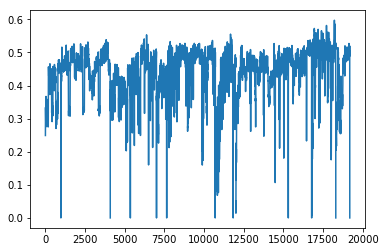

In [19]:
plt.plot(np.mean(inputOsu,axis=1))
plt.show()

In [15]:
np.mean(inputOsu[1])

0.28261643438368983

In [17]:
np.mean(inputOsu,axis=1)

array([ 0.2490236 ,  0.28261643,  0.30784057, ...,  0.        ,
        0.        ,  0.        ])

In [18]:
np.mean(inputOsu,axis=0)

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])